In [1]:
#import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [2]:
#conda install -c conda-forge imbalanced-learn

In [3]:
#pip install -U imbalanced-learn

### Load the data file

In [4]:
telco_base_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df=telco_base_data.copy()

### Look at the top 5 records of data

In [6]:
telco_base_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Check the various attributes of data like shape (rows and cols), Columns, datatypes

In [7]:
telco_base_data.shape

(7043, 21)

In [8]:
telco_base_data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [9]:
# Checking the data types of all the columns
telco_base_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [10]:
# Check the descriptive statistics of numeric variables
telco_base_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [11]:
#SeniorCitizen is actually a categorical hence the 25%-50%-75% distribution is not propoer

#75% customers have tenure less than 55 months

#Average Monthly charges are USD 64.76 whereas 25% customers pay more than USD 89.85 per month

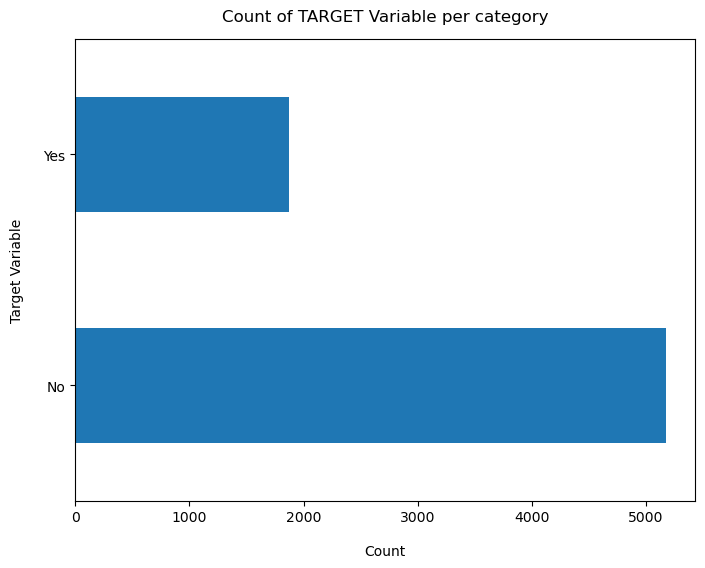

In [12]:
telco_base_data['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [13]:
100*telco_base_data['Churn'].value_counts()/len(telco_base_data['Churn'])

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

In [14]:
telco_base_data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

##### Data is imbalanced, ratio = 73:27
So we analyse the data with other features while taking the target values separately to get some insights.

In [15]:
# Concise Summary of the dataframe, as we have too many columns, we are using the verbose = True mode
telco_base_data.info(verbose = True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Data Cleaning

### 1. Create a copy of base data for manipulation & processing

In [16]:
telco_data = telco_base_data.copy()

### 2. Total Charges should be numeric amount. Let's convert it to numerical data type

In [17]:
telco_data.TotalCharges = pd.to_numeric(telco_data.TotalCharges, errors='coerce')
telco_data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### 3. As we can see there are 11 missing values in TotalCharges column. Let's check these records

In [18]:
telco_data.loc[telco_data ['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [19]:
telco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 4. Missing Value Treatement

#### Since the % of these records compared to total dataset is very low ie 0.15%, it is safe to ignore them from further processing.

In [20]:
#Removing missing values 
telco_data.dropna(how = 'any', inplace = True)

#telco_data.fillna(0)

### 5. Divide customers into bins based on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [21]:
# Get the max tenure
print(telco_data['tenure'].max()) #72

72


In [22]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)

In [23]:
telco_data['tenure_group'].value_counts()

1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: tenure_group, dtype: int64

### 6. Remove columns not required for processing

In [24]:
#drop column customerID and tenure
telco_data.drop(columns= ['customerID','tenure'], axis=1, inplace=True)
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


### Data Exploration

#### 1. Plot distibution of individual predictors by churn

##### Univariate Analysis

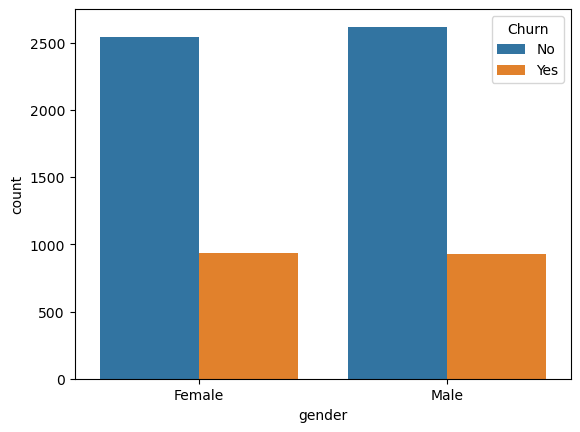

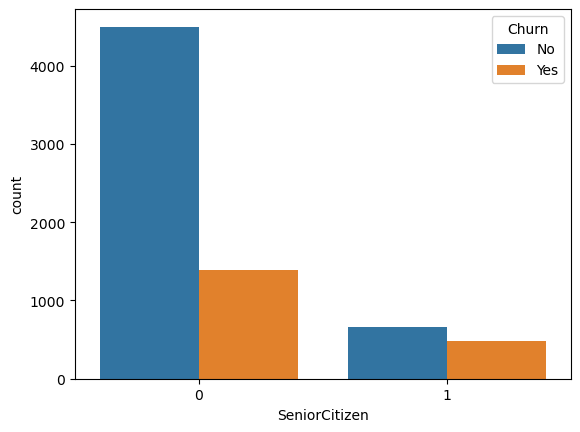

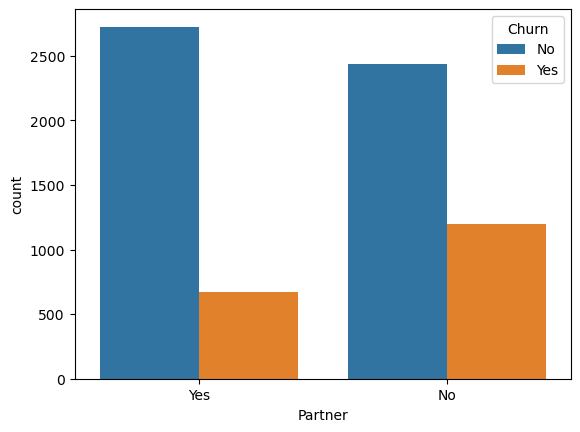

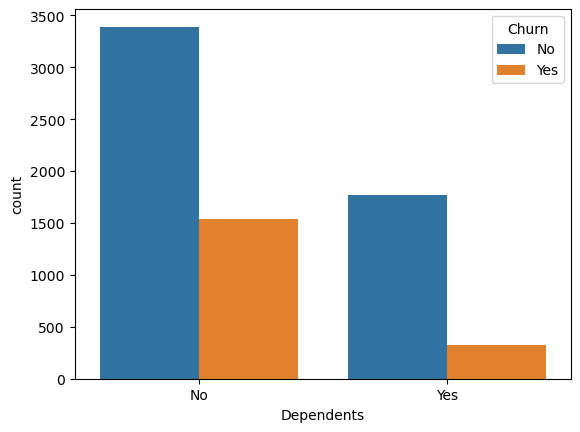

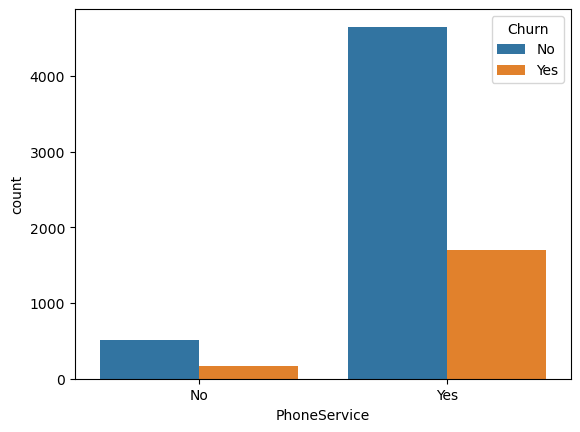

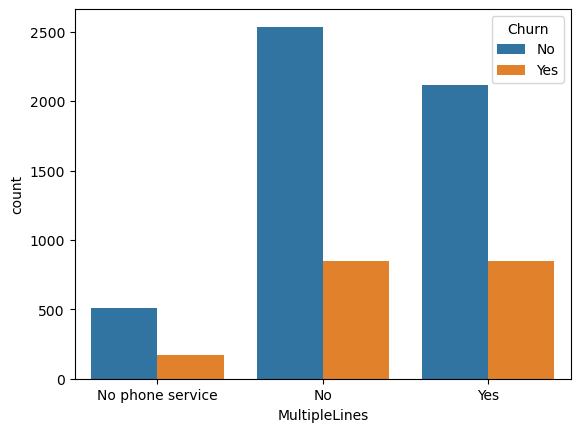

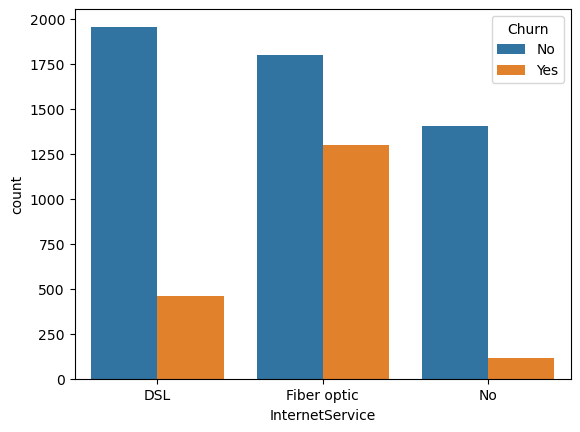

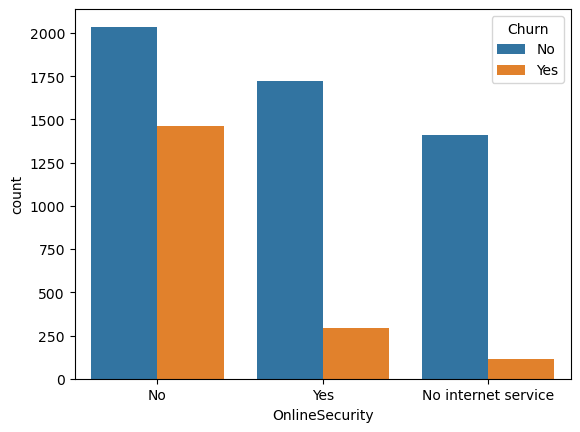

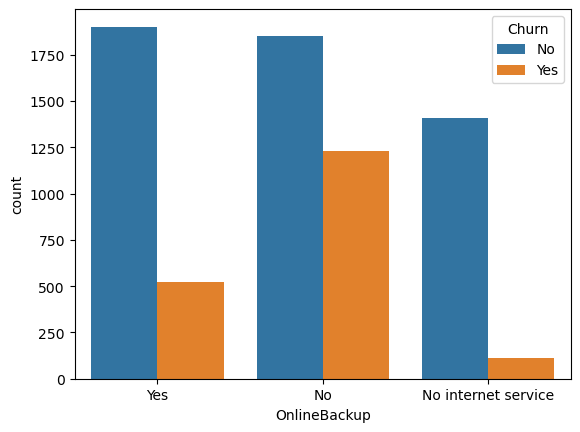

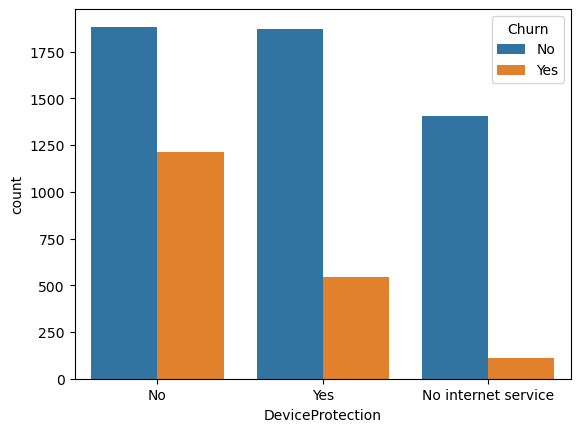

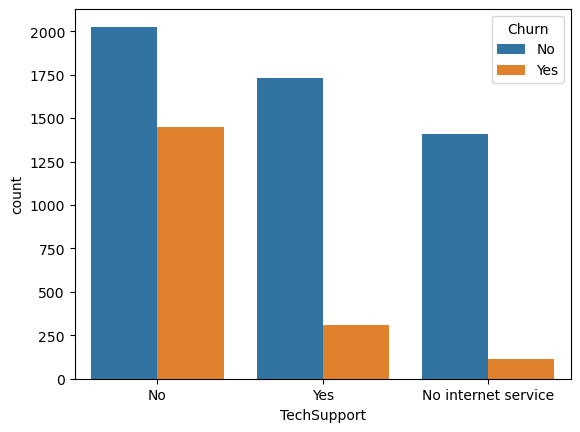

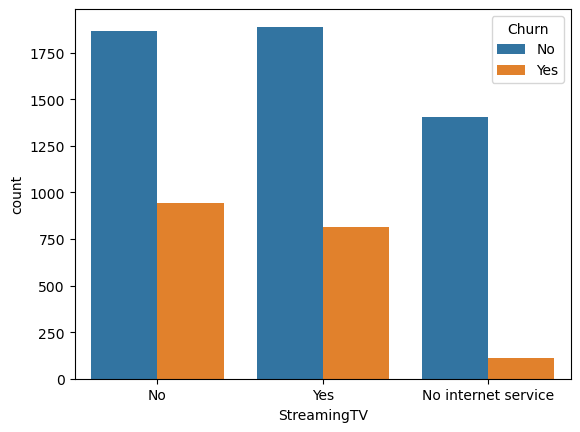

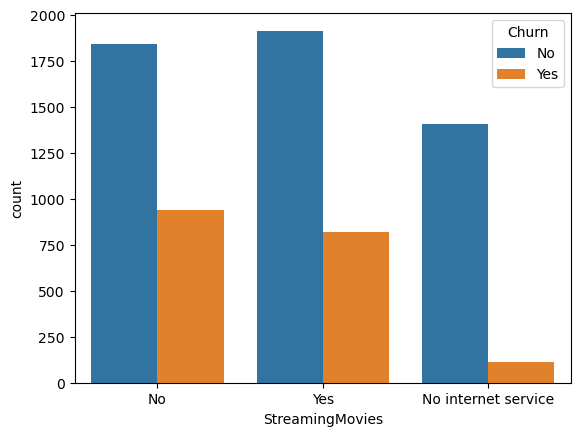

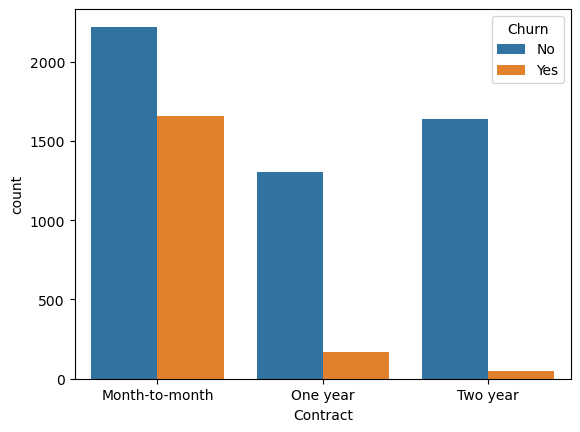

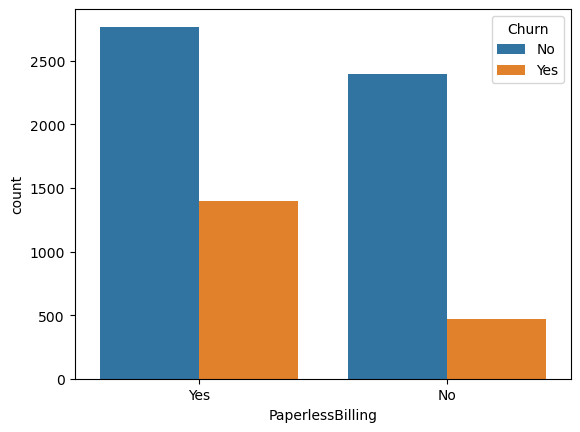

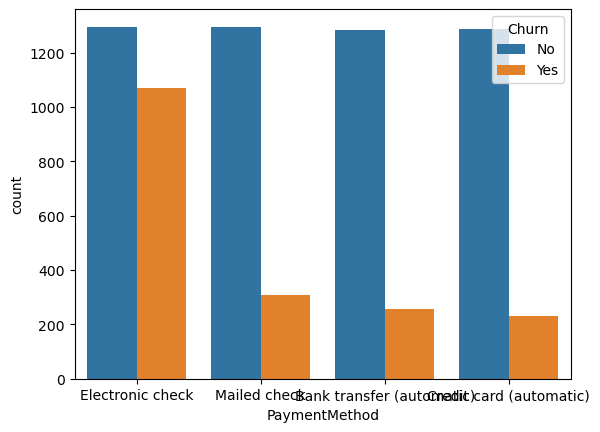

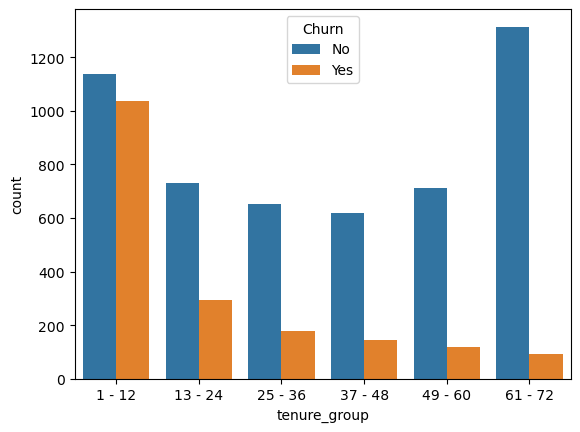

In [25]:
for i, predictor in enumerate(telco_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=telco_data, x=predictor, hue='Churn')

#### Analysis :
    
1.Gender- We can observe from the plot that Churn does not depend much on the Gender. As we can see both the Gender has simmilar kind of Churn ratio.

2.Partner - We can observe from the plot that if the Customer does not has a partner they are more prone to Churn. We need further dig deeper why this particular event is occuring. Post analysis we need to come up with strategies to retain these set of customers.

3.Dependents -  We can observe from the plot that if the Customer does not has a dependent they are more prone to Churn. We need further dig deeper why this particular event is occuring. Post analysis we need to come up with strategies to retain these set of customers.

4.Fiber Optic : We can observe from the plot that people who have opted for fiber optic are churning more compare to the people who are on DSL or not opted for any of the service. We need to find out why these particular event is happening with root cause analysis and come 
up with strategy to retain customer on these segment.

5.Online Security : We can observe from the plot that cusotmer with no online security has churned more.

6.Online Backup : We can observe from the plot that customer with no online back up has churned more.

7.Device Protection : We can observe from the plot that customer with no Device Protection has churned more.

8.Tech Support : We can observe from the plot that customer with No Tech Support has churned more.

9.Contract : We can observe from the plot that customers with month on month contract has churned more. Customers with one year contract or two year contract are less prone to churning.

10.PaperlessBilling : We can observe from the plot that more people has opted for Paperless Billing. Also we can see that Those people who 
have opted for paperless billing churned significantly.

11.Payment Method : We can observe from the plot that in Electronic Check the churn ratio is highest. We need to find out why this Segement has high churn ratio. Post that we have to build a strategy to retain our customer in this segment.

12.Tenure : We can observe from the plot that in 1-12 tenure group the churn ratio is highest but in case of higher tenure group the churn ratio is not that much. 

##### 2. Convert the target variable 'Churn' in a binary numeric variable i.e. Yes=1 ; No = 0

In [26]:
telco_data['Churn'] = np.where(telco_data.Churn == 'Yes',1,0)

In [27]:
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


#### 3. Convert all the categorical variables into dummy variables

In [28]:
telco_data_dummies = pd.get_dummies(telco_data)
telco_data_dummies.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108.15,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151.65,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


##### 9. Relationship between Monthly Charges and Total Charges

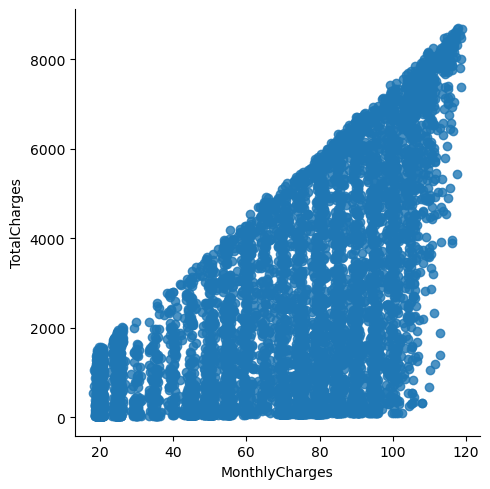

In [29]:
sns.lmplot(data=telco_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

##### Total Charges increase as Monthly Charges increase - as expected.

#### 10. Churn by Monthly Charges and Total Charges

C:\Users\ramit\AppData\Local\Temp\ipykernel_8736\722082952.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0) ],
C:\Users\ramit\AppData\Local\Temp\ipykernel_8736\722082952.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1) ],


Text(0.5, 1.0, 'Monthly charges by churn')

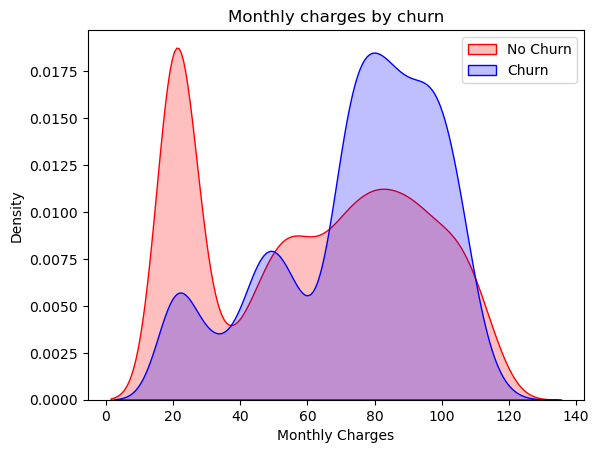

In [30]:
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

#### Insight: Churn is high when Monthly Charges ar high

C:\Users\ramit\AppData\Local\Temp\ipykernel_8736\4019118049.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0) ],
C:\Users\ramit\AppData\Local\Temp\ipykernel_8736\4019118049.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1) ],


Text(0.5, 1.0, 'Total charges by churn')

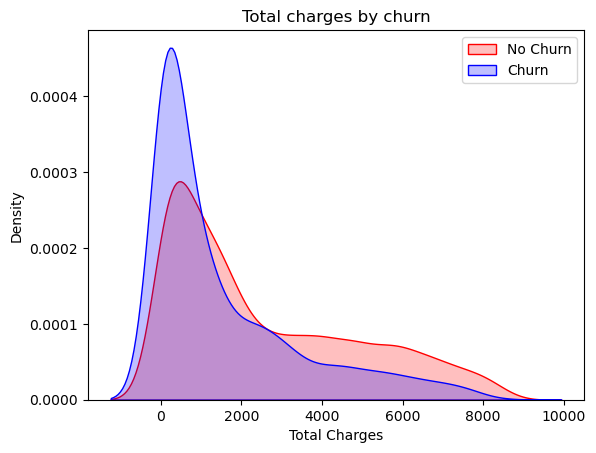

In [31]:
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

##### Surprising insight as higher Churn at lower Total Charges

However if we combine the insights of 3 parameters i.e. Tenure, Monthly Charges & Total Charges then the picture is bit clear :- Higher Monthly Charge at lower tenure results into lower Total Charge. Hence, all these 3 factors viz Higher Monthly Charge, Lower tenure and Lower Total Charge are linkd to High Churn.

#### 11. Build a corelation of all predictors with 'Churn'

<AxesSubplot:>

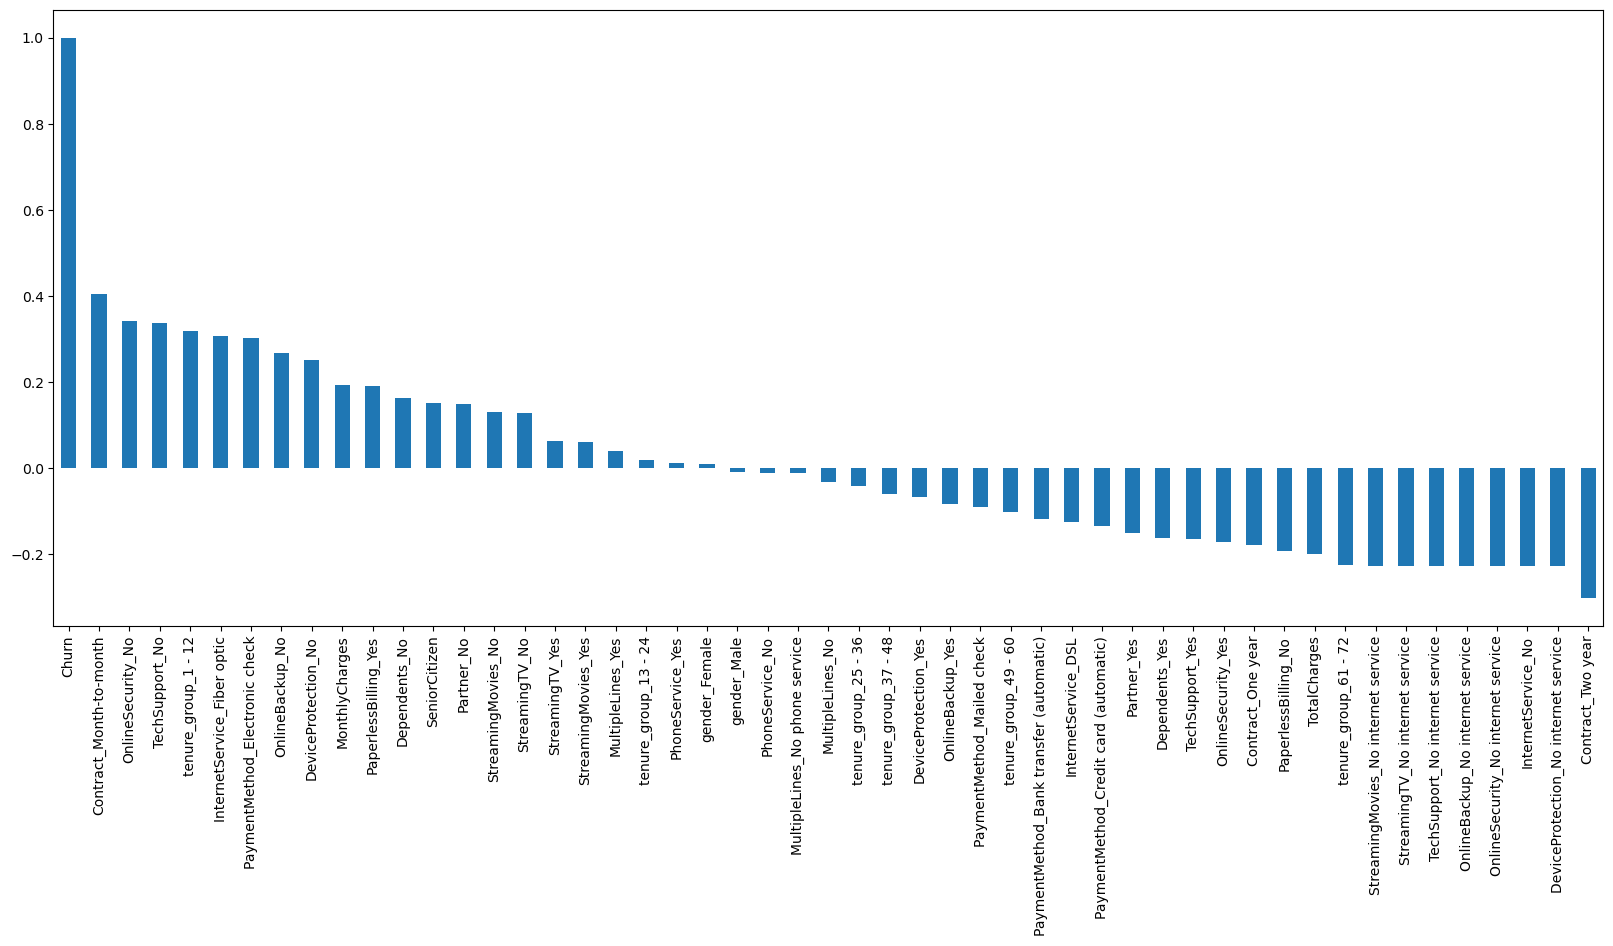

In [32]:
plt.figure(figsize=(20,8))
telco_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

#### Derived Insight:

HIGH Churn seen in case of Month to month contracts, No online security, No Tech support, First year of subscription and Fibre Optics Internet

LOW Churn is seens in case of Long term contracts, Subscriptions without internet service and The customers engaged for 5+ years

Factors like Gender, Availability of PhoneService and # of multiple lines have alomost NO impact on Churn


<AxesSubplot:>

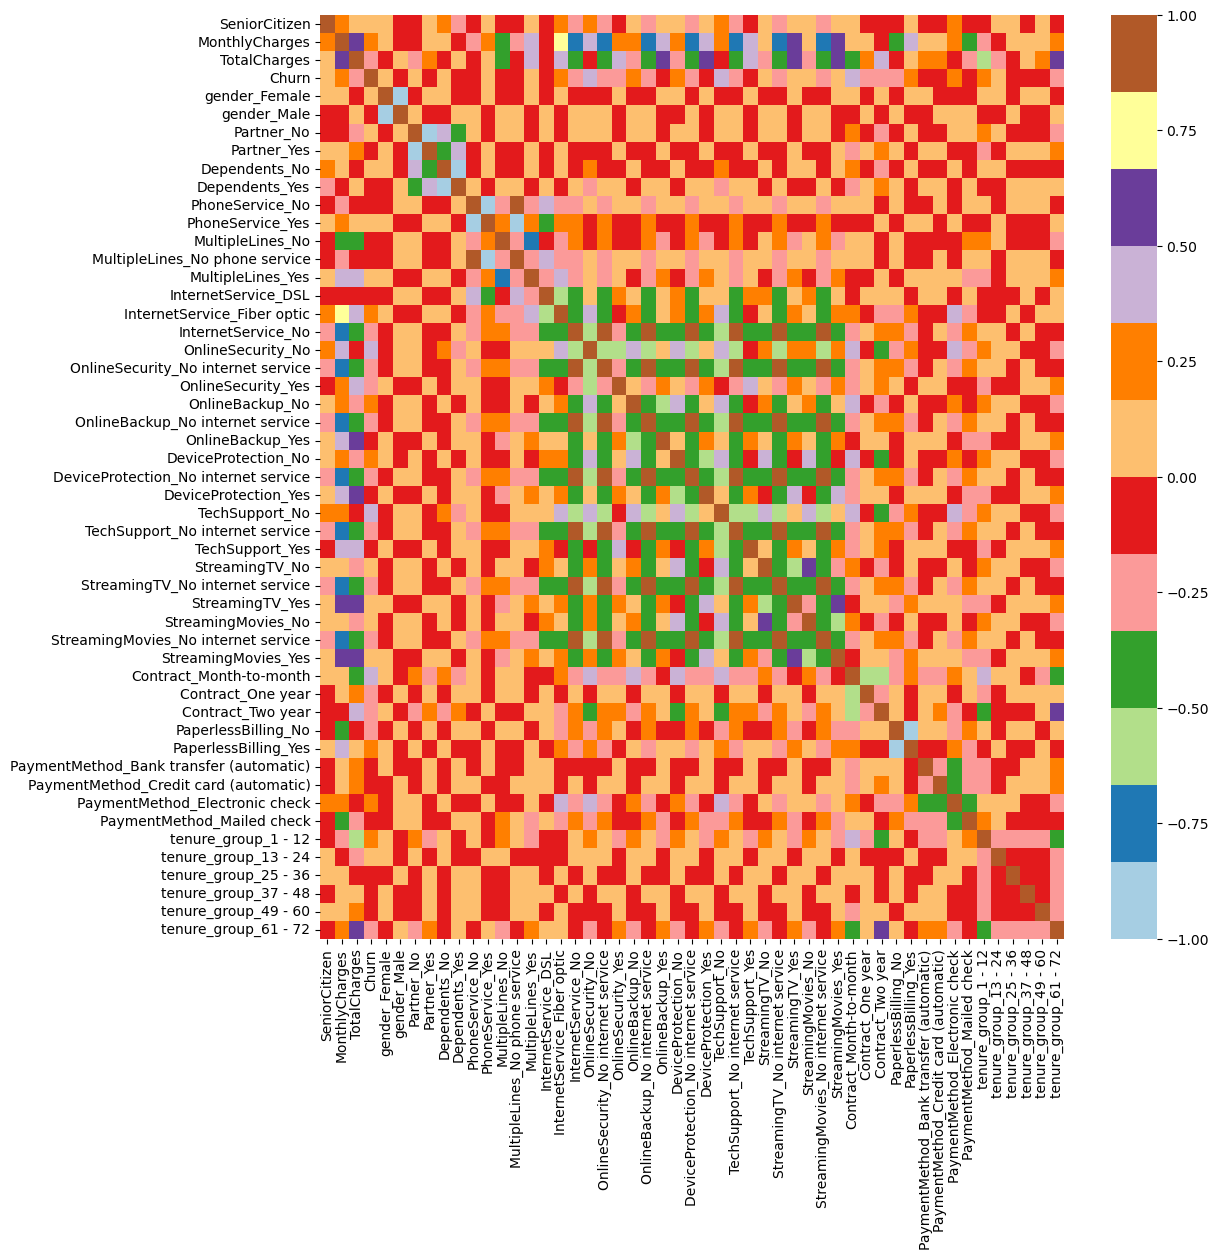

In [33]:
plt.figure(figsize=(12,12))
sns.heatmap(telco_data_dummies.corr(), cmap="Paired")

### Bivariate Analysis

In [34]:
new_df1_target0=telco_data.loc[telco_data["Churn"]==0]
new_df1_target1=telco_data.loc[telco_data["Churn"]==1]

In [35]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

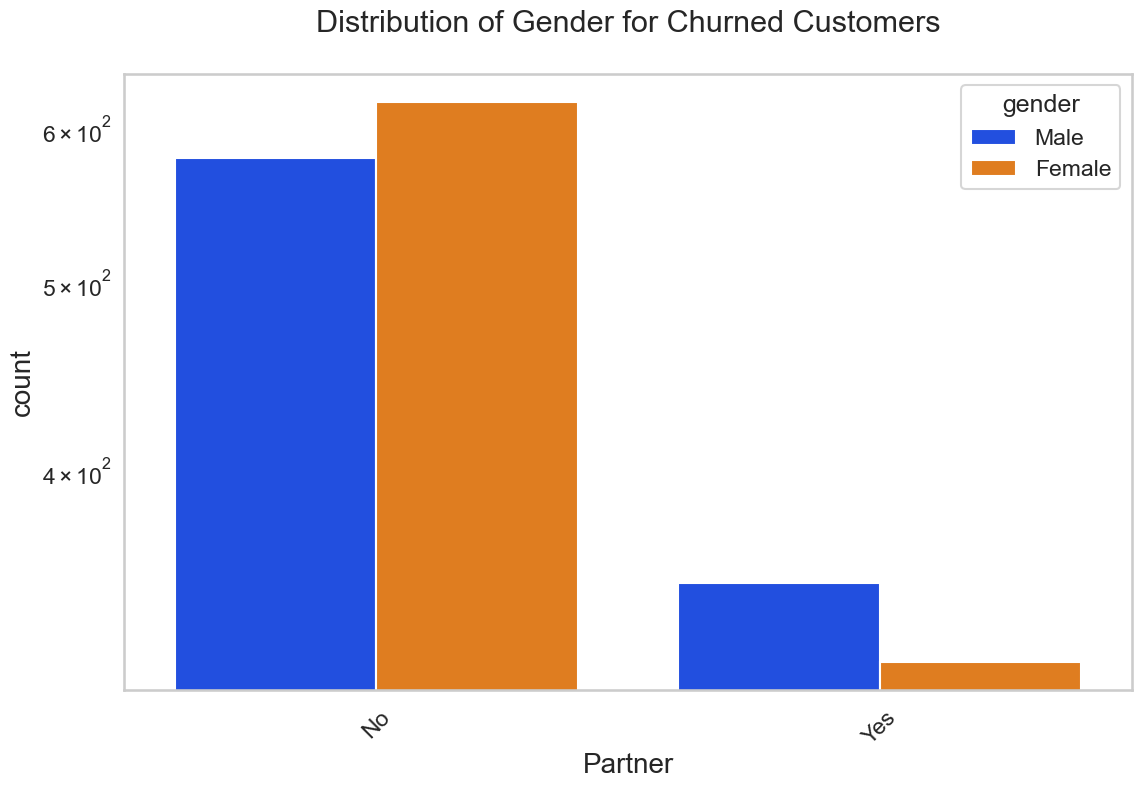

In [36]:
uniplot(new_df1_target1,col='Partner',title='Distribution of Gender for Churned Customers',hue='gender')

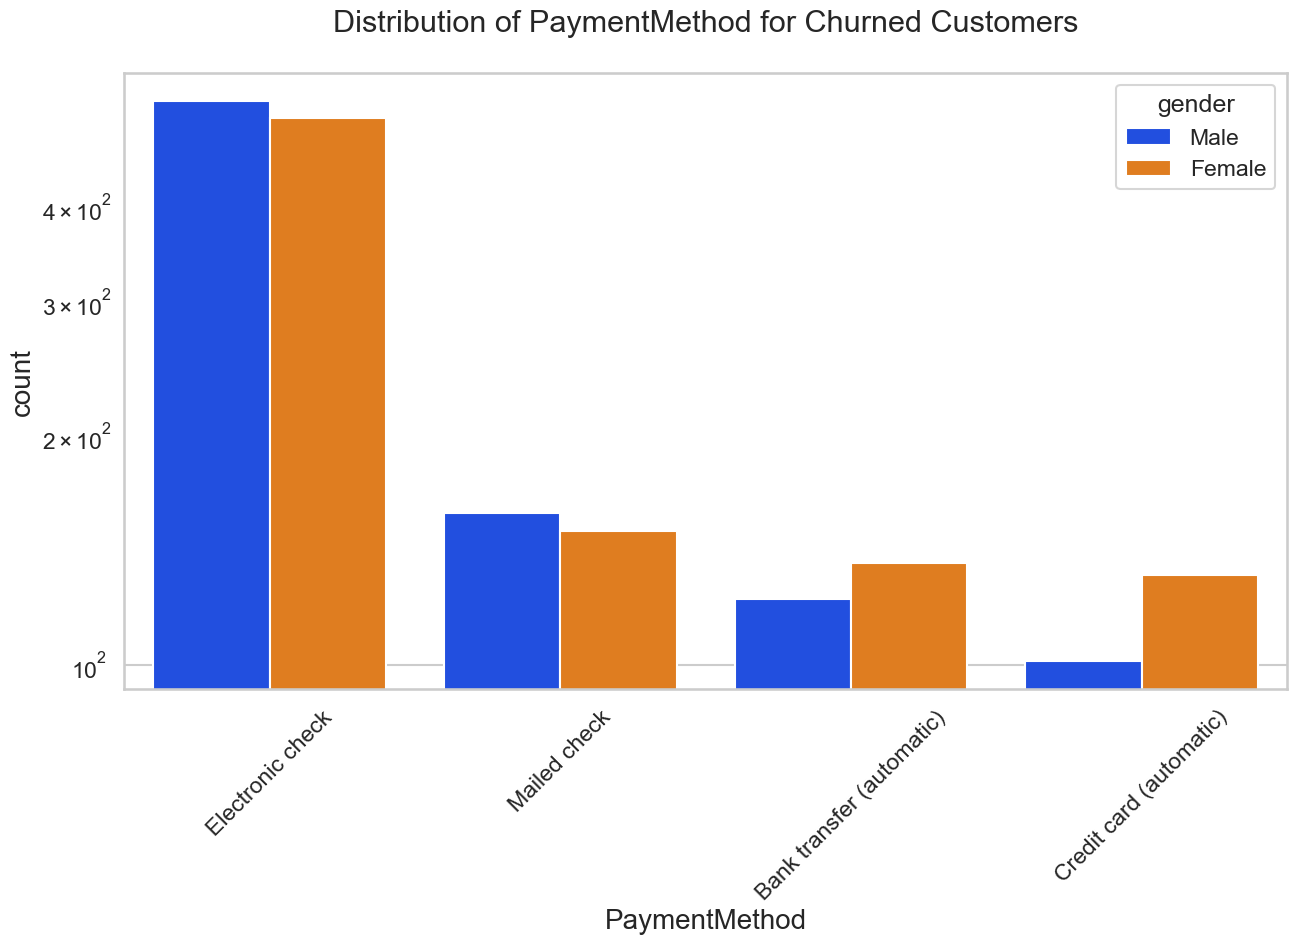

In [37]:
uniplot(new_df1_target1,col='PaymentMethod',title='Distribution of PaymentMethod for Churned Customers',hue='gender')

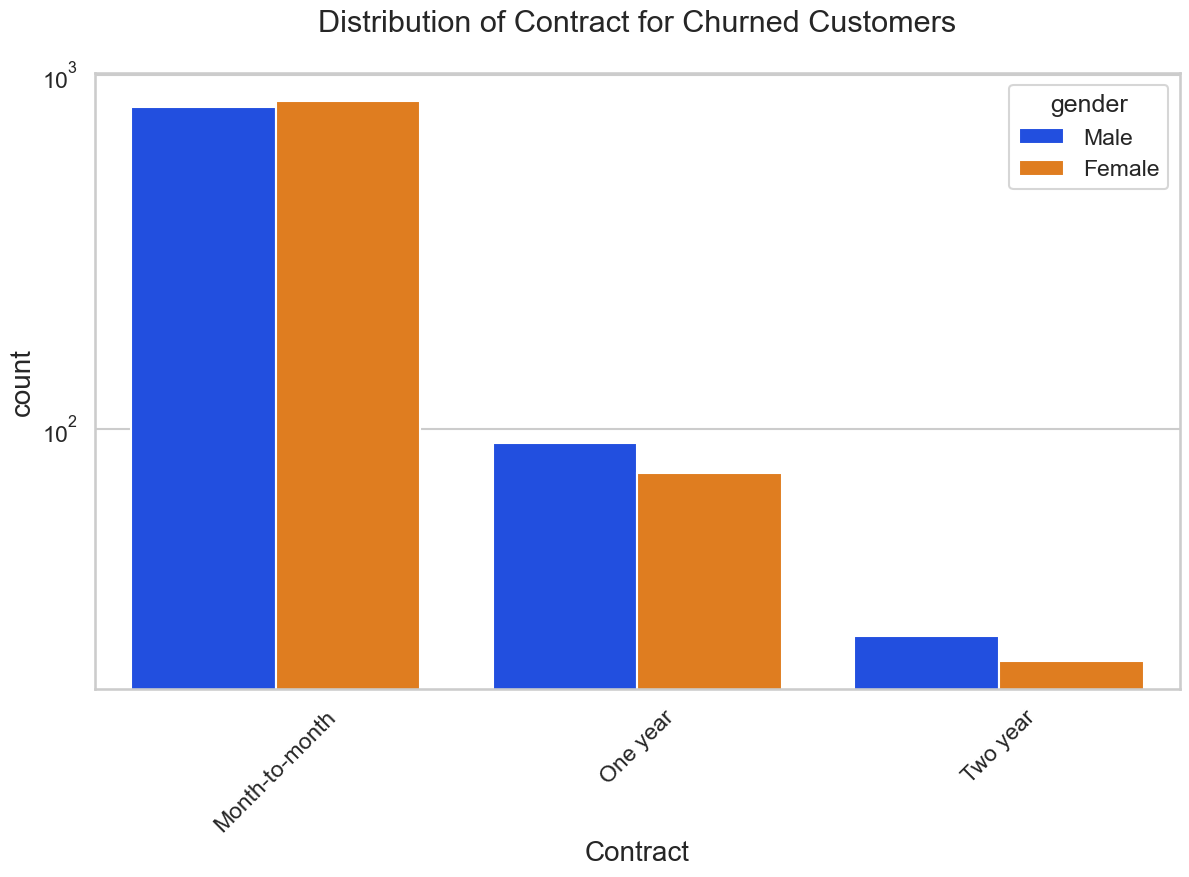

In [38]:

uniplot(new_df1_target1,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')

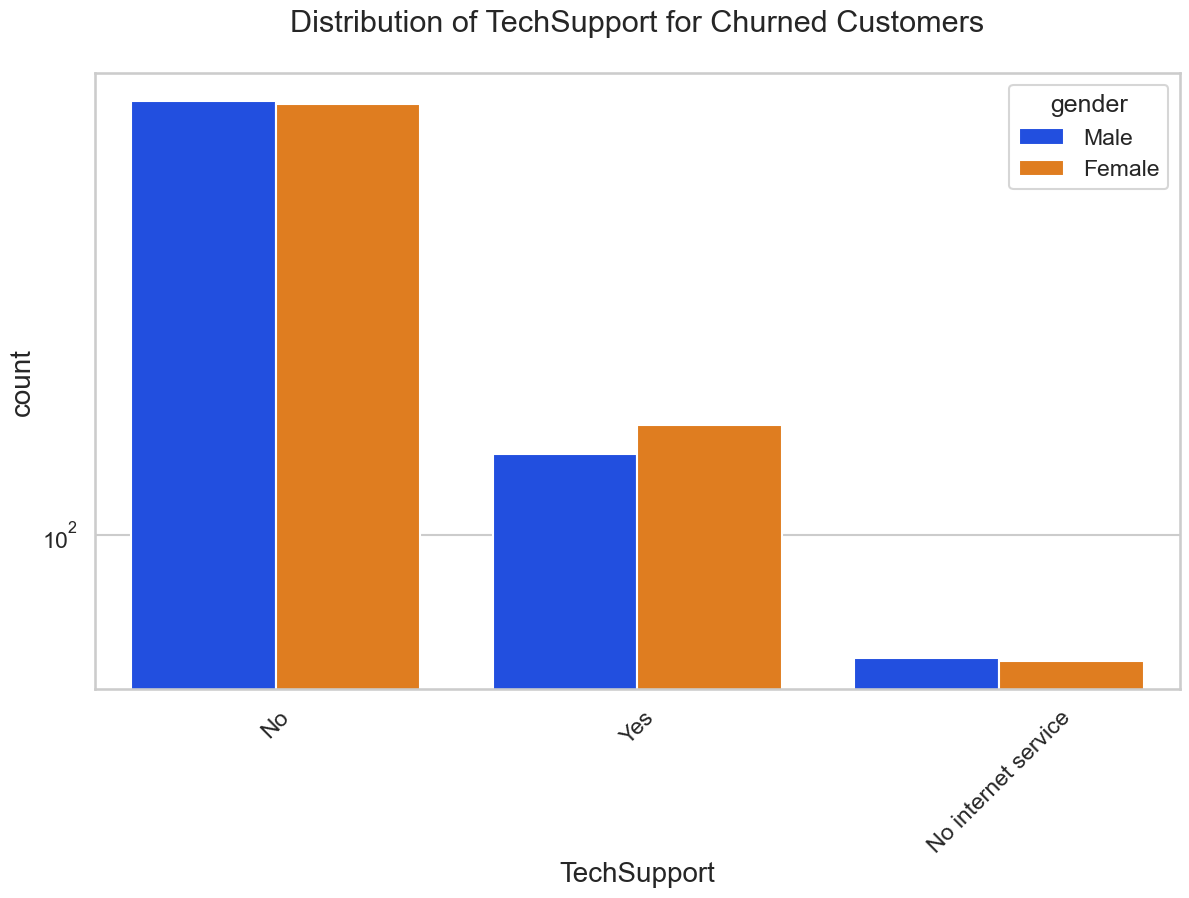

In [39]:
uniplot(new_df1_target1,col='TechSupport',title='Distribution of TechSupport for Churned Customers',hue='gender')

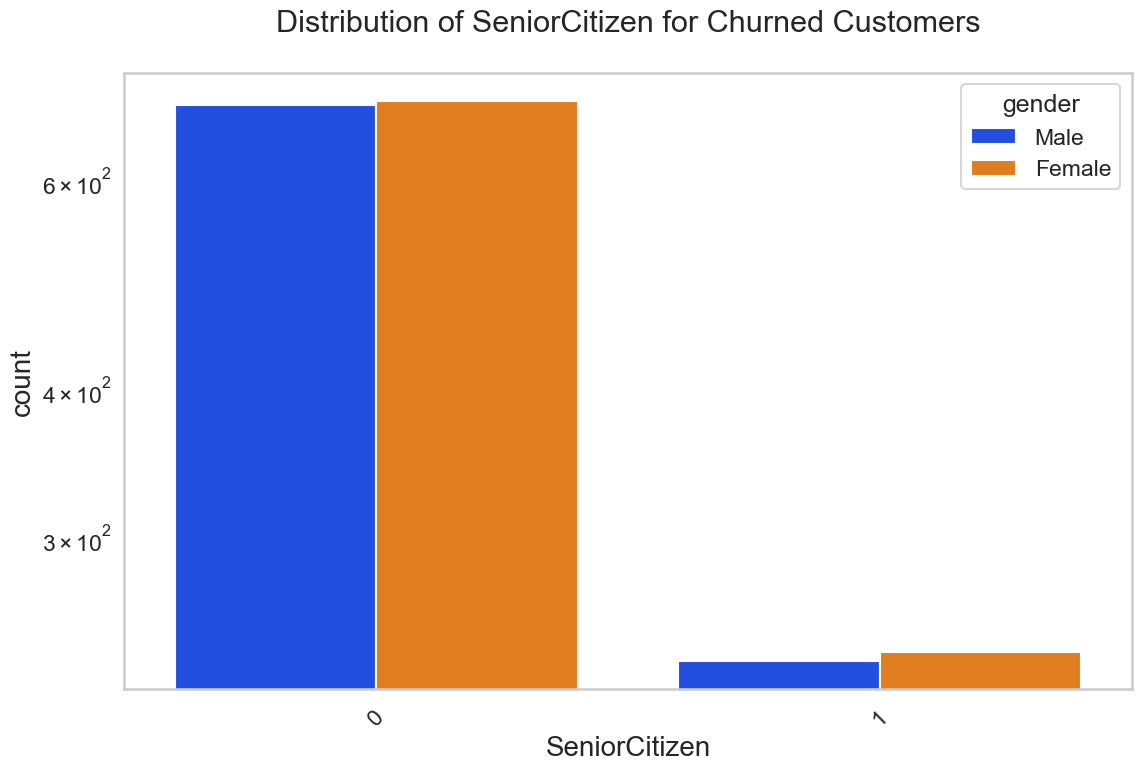

In [40]:
uniplot(new_df1_target1,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')

### CONCLUSION
These are some of the quick insights from this exercise:

1.Electronic check medium are the highest churners   
2.Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.  
3.No Online security, No Tech Support category are high churners  
4.Non senior Citizens are high churners


### Model Building

In [41]:
df=telco_base_data.copy()

In [42]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [43]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [44]:
# Converting Total Charges to a numerical data type.
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [45]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [46]:
#Removing missing values 
df.dropna(inplace = True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [48]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [49]:
import warnings
warnings.filterwarnings('ignore')

### How many rows have missing ID ?

In [50]:
df['customerID'].isnull().sum()

0

### Drop ID Feature from the dataset

In [51]:
df=df.drop(['customerID'],axis=1)

### Label the Churn feature to 1/0

In [52]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [53]:
df['target']=np.where(df['Churn']=="Yes",1,0)

In [54]:
df['target'].info()

<class 'pandas.core.series.Series'>
Int64Index: 7032 entries, 0 to 7042
Series name: target
Non-Null Count  Dtype
--------------  -----
7032 non-null   int32
dtypes: int32(1)
memory usage: 82.4 KB


### Drop the Churn feature to retain only Target

In [55]:
df=df.drop(['Churn'],axis=1)

### Defining Target and Independent Features

In [56]:
Y=df[['target']]
X=df.drop(['target'],axis=1)

In [57]:
Y.head()

,target
0,0
1,0
2,1
3,0
4,1


### Split features into Numerical and Categorical

In [58]:
num=X.select_dtypes(include="number")
char=X.select_dtypes(include="object")

In [59]:
num.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [60]:
#Checking whether SeniorCitizon feaure is an indicator
num.SeniorCitizen.value_counts()

0    5890
1    1142
Name: SeniorCitizen, dtype: int64

In [61]:
char.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


### Dropping the indicator features from num to build a separate DF

In [62]:
ind=num[['SeniorCitizen']]
num=num.drop(['SeniorCitizen'],axis=1)

In [63]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7032 non-null   int64  
 1   MonthlyCharges  7032 non-null   float64
 2   TotalCharges    7032 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 219.8 KB


### Outlier Analysis of Numerical Features

In [64]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.9,0.99])

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
1%,1.000000,19.200000,19.900000
5%,1.000000,19.650000,49.605000
10%,2.000000,20.050000,84.600000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500


In [65]:
num.isnull().sum()

tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64

### Since the data does not contain any missing values Imputation Processes are not required

### Feature Selection - Numerical Features

In [66]:
rfr_model_num =RandomForestRegressor()
rfr_model_num.fit(num,Y)
rfr_model_num.feature_importances_

array([0.24014881, 0.41536225, 0.34448893])

<AxesSubplot:>

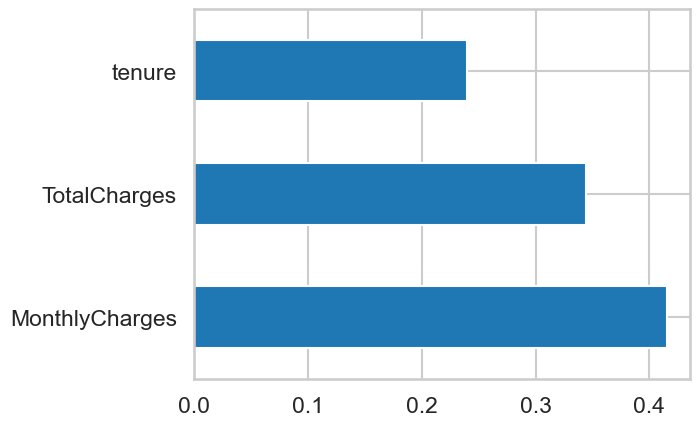

In [67]:
feature_imp = pd.Series(rfr_model_num.feature_importances_,index=num.columns)
feature_imp.nlargest(3).plot(kind='barh')

### Dummification of Categorical Variable

In [68]:
X_char_dum = pd.get_dummies(char, drop_first = True)
X_char_dum.shape

(7032, 26)

#### Feature Importance using Random Forest Classifier

In [69]:
rfr_model_char = RandomForestClassifier()
rfr_model_char.fit(X_char_dum,Y)
rfr_model_char.feature_importances_

array([0.06934243, 0.05376828, 0.04704717, 0.00852448, 0.00840791,
       0.05401247, 0.06791029, 0.00817797, 0.00644233, 0.05760811,
       0.00383391, 0.05379719, 0.00564285, 0.05356218, 0.00470851,
       0.05955703, 0.00657723, 0.05466965, 0.00792911, 0.05466204,
       0.06360165, 0.07211249, 0.05643089, 0.03203601, 0.06469861,
       0.02493921])

<AxesSubplot:>

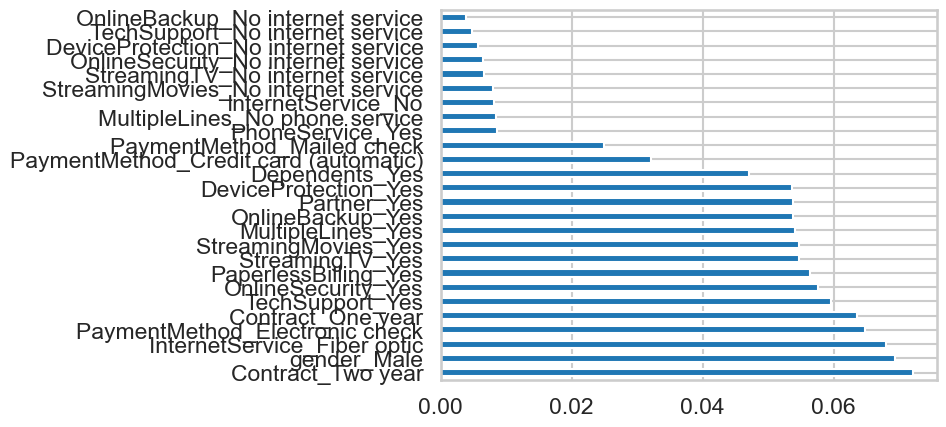

In [70]:
feature_imp = pd.Series(rfr_model_char.feature_importances_,X_char_dum.columns)
feature_imp.nlargest(26).plot(kind='barh')

<AxesSubplot:>

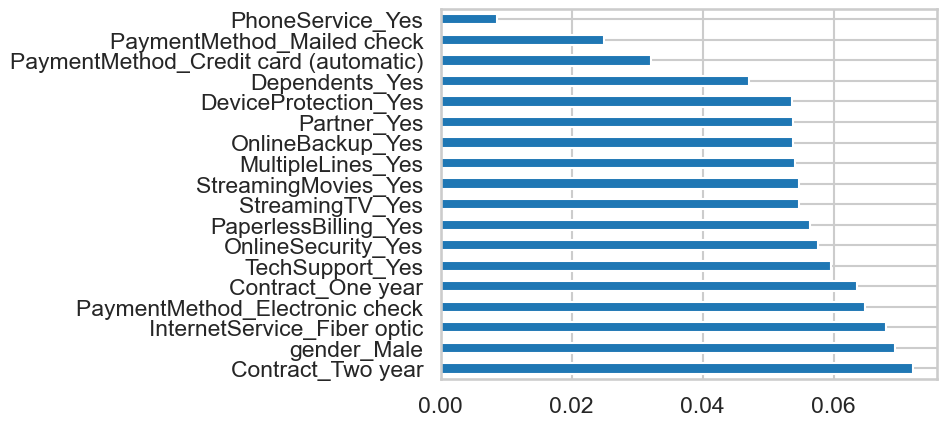

In [71]:
feature_imp = pd.Series(rfr_model_char.feature_importances_,X_char_dum.columns)
feature_imp.nlargest(18).plot(kind='barh')

In [72]:
feature_imp.nlargest(18)

Contract_Two year                        0.072112
gender_Male                              0.069342
InternetService_Fiber optic              0.067910
PaymentMethod_Electronic check           0.064699
Contract_One year                        0.063602
TechSupport_Yes                          0.059557
OnlineSecurity_Yes                       0.057608
PaperlessBilling_Yes                     0.056431
StreamingTV_Yes                          0.054670
StreamingMovies_Yes                      0.054662
MultipleLines_Yes                        0.054012
OnlineBackup_Yes                         0.053797
Partner_Yes                              0.053768
DeviceProtection_Yes                     0.053562
Dependents_Yes                           0.047047
PaymentMethod_Credit card (automatic)    0.032036
PaymentMethod_Mailed check               0.024939
PhoneService_Yes                         0.008524
dtype: float64

In [73]:
X_char_dum.head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [74]:
#X_char_sel=X_char_dum[['Contract_Month-to-month','OnlineSecurity_No','PaymentMethod_Electronic check','TechSupport_No','Contract_Two year','gender_Female','gender_Male','InternetService_Fiber optic','OnlineBackup_No','DeviceProtection_No','MultipleLines_Yes','MultipleLines_No','StreamingTV_Yes','StreamingMovies_Yes','StreamingMovies_No','PaymentMethod_Credit card (automatic)','StreamingTV_No','DeviceProtection_Yes','PaperlessBilling_Yes','Partner_Yes','Partner_No']]

In [75]:
X_char_sel=X_char_dum

In [76]:
X_char_sel.head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [77]:
X_ind_merged=pd.concat([Y,ind],axis=1,join='inner')


In [78]:
select_features_df_ind=ind

#### Selecting All the features and Storing to X_all

In [79]:
X_all=pd.concat([X_char_sel,num,ind],axis=1,join="inner")

In [80]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender_Male                            7032 non-null   uint8  
 1   Partner_Yes                            7032 non-null   uint8  
 2   Dependents_Yes                         7032 non-null   uint8  
 3   PhoneService_Yes                       7032 non-null   uint8  
 4   MultipleLines_No phone service         7032 non-null   uint8  
 5   MultipleLines_Yes                      7032 non-null   uint8  
 6   InternetService_Fiber optic            7032 non-null   uint8  
 7   InternetService_No                     7032 non-null   uint8  
 8   OnlineSecurity_No internet service     7032 non-null   uint8  
 9   OnlineSecurity_Yes                     7032 non-null   uint8  
 10  OnlineBackup_No internet service       7032 non-null   uint8  
 11  Onli

In [81]:
Y['target'].value_counts()

0    5163
1    1869
Name: target, dtype: int64

### Train Test Split

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_all, Y, test_size=0.3, random_state=10)

In [83]:
print("Shape of Training Data",X_train.shape)
print("Shape of Testing Data",X_test.shape)
print("Response Rate in Training Data",y_train.mean())
print("Response Rate in Testing Data",y_test.mean())

Shape of Training Data (4922, 30)
Shape of Testing Data (2110, 30)
Response Rate in Training Data target    0.266152
dtype: float64
Response Rate in Testing Data target    0.264929
dtype: float64


### Building Model - Using All the Features 

#### Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=0)
logreg.fit(X_train,y_train)

LogisticRegression(random_state=0)

#### Decision Tree Classifier

In [169]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(criterion='gini',random_state=0)

In [176]:
max_features_range = np.arange(1,6,1)
param_grid = dict(max_features=max_features_range,max_depth=[1,2,3,4,5])
grid_cv_tree = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=3)
grid_cv_tree.fit(X_train,y_train)
print(grid_cv_tree.best_params_)

{'max_depth': 4, 'max_features': 4}


### Random Forest Classifier

In [88]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(criterion='gini',random_state=0)

In [189]:
max_features_range = np.arange(1,6,1)
param_grid = dict(max_features=max_features_range,max_depth=[4,5,6,7,8],n_estimators=[100,200,50])
grid_cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_cv_rf.fit(X_train,y_train)
print(grid_cv_rf.best_params_)

{'max_depth': 6, 'max_features': 5, 'n_estimators': 50}


In [190]:
y_pred_logreg=logreg.predict(X_test)
y_pred_tree=grid_cv_tree.predict(X_test)
y_pred_rf=grid_cv_rf.predict(X_test)
y_pred_logreg_train=logreg.predict(X_train)
y_pred_tree_train=grid_cv_tree.predict(X_train)
y_pred_rf_train=grid_cv_rf.predict(X_train)


In [92]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Metrics of Logistic Regression

In [179]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_logreg))
print("Precision",metrics.precision_score(y_test,y_pred_logreg))
print("Recall",metrics.recall_score(y_test,y_pred_logreg))
print("f1_score_test",metrics.f1_score(y_test,y_pred_logreg))
print("f1_score_train",metrics.f1_score(y_train,y_pred_logreg_train))

Accuracy: 0.8052132701421801
Precision 0.6548117154811716
Recall 0.5599284436493739
f1_score_test 0.6036644165863065
f1_score_train 0.5878864887759424


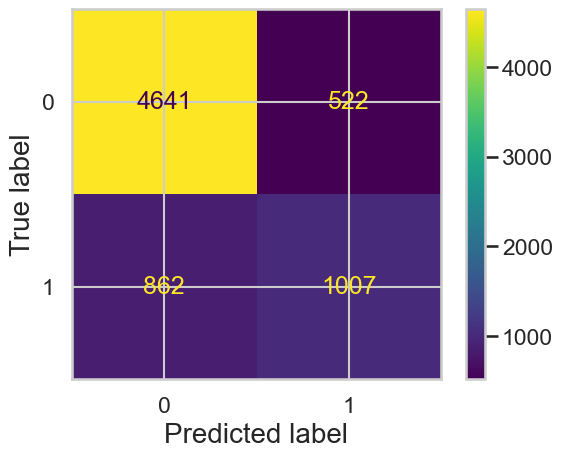

In [180]:
metrics.plot_confusion_matrix(logreg,X_all,Y)

### Metrics of Decision Tree Classifier

In [181]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_tree))
print("Precision",metrics.precision_score(y_test,y_pred_tree))
print("Recall",metrics.recall_score(y_test,y_pred_tree))
print("f1_score_test",metrics.f1_score(y_test,y_pred_tree))
print("f1_score_train",metrics.f1_score(y_train,y_pred_tree_train))

Accuracy: 0.785781990521327
Precision 0.6213151927437641
Recall 0.49016100178890876
f1_score_test 0.548
f1_score_train 0.5602117335685929


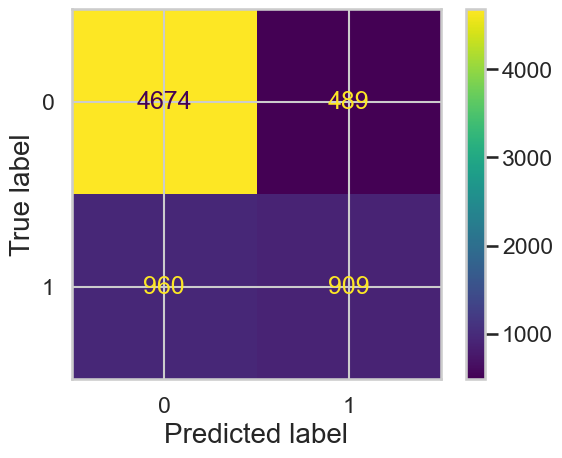

In [184]:
metrics.plot_confusion_matrix(grid_cv_tree,X_all,Y)

### Metrics Of Random Forest Classifier

In [191]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision",metrics.precision_score(y_test,y_pred_rf))
print("Recall",metrics.recall_score(y_test,y_pred_rf))
print("f1_score_test",metrics.f1_score(y_test,y_pred_rf))
print("f1_score_train",metrics.f1_score(y_train,y_pred_rf_train))

Accuracy: 0.795260663507109
Precision 0.6552567237163814
Recall 0.47942754919499103
f1_score_test 0.5537190082644629
f1_score_train 0.5568130375735627


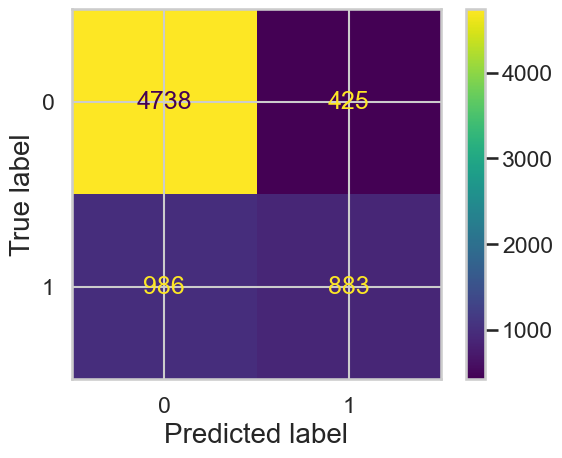

In [192]:
metrics.plot_confusion_matrix(grid_cv_rf,X_all,Y)

### Feature Selection Based on Feature Importance, We are using Top 15 features

In [99]:
X_char_selc=X_char_dum[['Contract_Two year','gender_Male','Contract_One year','InternetService_Fiber optic','PaymentMethod_Electronic check','OnlineBackup_Yes','OnlineSecurity_Yes','StreamingMovies_Yes','TechSupport_Yes','Partner_Yes','MultipleLines_Yes','DeviceProtection_Yes','PaperlessBilling_Yes','StreamingTV_Yes','Dependents_Yes']]

In [100]:
X_char_selc.head()

,Contract_Two year,gender_Male,Contract_One year,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_Yes,OnlineSecurity_Yes,StreamingMovies_Yes,TechSupport_Yes,Partner_Yes,MultipleLines_Yes,DeviceProtection_Yes,PaperlessBilling_Yes,StreamingTV_Yes,Dependents_Yes
0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0
1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
3,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0
4,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0


In [101]:
X_char_selc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Contract_Two year               7032 non-null   uint8
 1   gender_Male                     7032 non-null   uint8
 2   Contract_One year               7032 non-null   uint8
 3   InternetService_Fiber optic     7032 non-null   uint8
 4   PaymentMethod_Electronic check  7032 non-null   uint8
 5   OnlineBackup_Yes                7032 non-null   uint8
 6   OnlineSecurity_Yes              7032 non-null   uint8
 7   StreamingMovies_Yes             7032 non-null   uint8
 8   TechSupport_Yes                 7032 non-null   uint8
 9   Partner_Yes                     7032 non-null   uint8
 10  MultipleLines_Yes               7032 non-null   uint8
 11  DeviceProtection_Yes            7032 non-null   uint8
 12  PaperlessBilling_Yes            7032 non-null   uint8
 13  Str

In [102]:
X_tot=pd.concat([X_char_selc,num,ind],axis=1,join="inner")

In [103]:
X_tot.head()

,Contract_Two year,gender_Male,Contract_One year,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_Yes,OnlineSecurity_Yes,StreamingMovies_Yes,TechSupport_Yes,Partner_Yes,MultipleLines_Yes,DeviceProtection_Yes,PaperlessBilling_Yes,StreamingTV_Yes,Dependents_Yes,tenure,MonthlyCharges,TotalCharges,SeniorCitizen
0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,29.85,29.85,0
1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,34,56.95,1889.50,0
2,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,2,53.85,108.15,0
3,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,45,42.30,1840.75,0
4,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,2,70.70,151.65,0


### Building Model with Selected features

In [104]:
from sklearn.model_selection import train_test_split
X_train_tot, X_test_tot, y_train_tot, y_test_tot=train_test_split(X_tot, Y, test_size=0.3, random_state=10)

#### Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression
logreg_tot=LogisticRegression(random_state=0)
logreg_tot.fit(X_train_tot,y_train_tot)

LogisticRegression(random_state=0)

#### Decision Tree Classifier

In [193]:
from sklearn.tree import DecisionTreeClassifier
dtree_tot=DecisionTreeClassifier(criterion='gini',random_state=0)

In [194]:
max_features_range = np.arange(1,6,1)
param_grid = dict(max_features=max_features_range,max_depth=[1,2,3,4,5])
grid_cv_tree_tot = GridSearchCV(estimator=dtree_tot, param_grid=param_grid, cv=3)
grid_cv_tree_tot.fit(X_train_tot,y_train_tot)
print(grid_cv_tree_tot.best_params_)

{'max_depth': 2, 'max_features': 4}


#### Random Forest Classifier

In [195]:
from sklearn.ensemble import RandomForestClassifier
rf_tot=RandomForestClassifier(criterion='gini',random_state=0)


In [199]:
max_features_range = np.arange(1,6,1)
param_grid = dict(max_features=max_features_range,max_depth=[4,5,6,7,8],n_estimators=[100,200,50])
grid_cv_rf_tot = GridSearchCV(estimator=rf_tot, param_grid=param_grid, cv=3)
grid_cv_rf_tot.fit(X_train_tot,y_train_tot)
print(grid_cv_rf_tot.best_params_)

{'max_depth': 8, 'max_features': 4, 'n_estimators': 50}


In [200]:
y_pred_logreg_tot=logreg_tot.predict(X_test_tot)
y_pred_tree_tot=grid_cv_tree_tot.predict(X_test_tot)
y_pred_rf_tot=grid_cv_rf_tot.predict(X_test_tot)
y_pred_logreg_train_tot=logreg_tot.predict(X_train_tot)
y_pred_tree_train_tot=grid_cv_tree_tot.predict(X_train_tot)
y_pred_rf_train_tot=grid_cv_rf_tot.predict(X_train_tot)

#### Metrics of Logistics Regression

In [201]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [202]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_tot, y_pred_logreg_tot))
print("Precision",metrics.precision_score(y_test_tot,y_pred_logreg_tot))
print("Recall",metrics.recall_score(y_test_tot,y_pred_logreg_tot))
print("f1_score_test",metrics.f1_score(y_test_tot,y_pred_logreg_tot))
print("f1_score_train",metrics.f1_score(y_train_tot,y_pred_logreg_train_tot))

Accuracy: 0.8061611374407583
Precision 0.665929203539823
Recall 0.5384615384615384
f1_score_test 0.5954500494559842
f1_score_train 0.5731497418244407


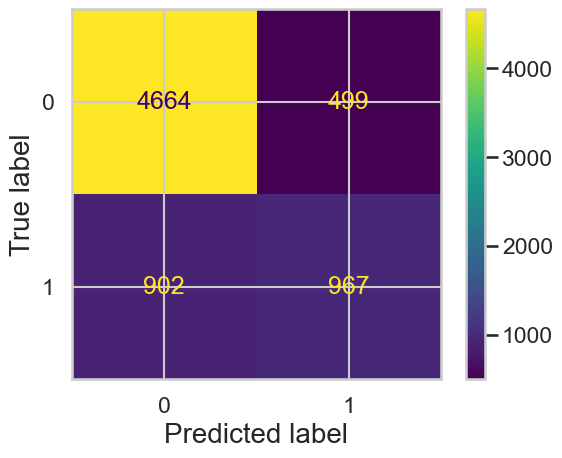

In [203]:
metrics.plot_confusion_matrix(logreg_tot,X_tot,Y)

#### Metrics of Decision Tree Classifier

In [204]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_tot, y_pred_tree_tot))
print("Precision",metrics.precision_score(y_test_tot,y_pred_tree_tot))
print("Recall",metrics.recall_score(y_test_tot,y_pred_tree_tot))
print("f1_score_test",metrics.f1_score(y_test_tot,y_pred_tree_tot))
print("f1_score_train",metrics.f1_score(y_train_tot,y_pred_tree_train_tot))

Accuracy: 0.7933649289099526
Precision 0.6803519061583577
Recall 0.4150268336314848
f1_score_test 0.5155555555555555
f1_score_train 0.5045302813543158


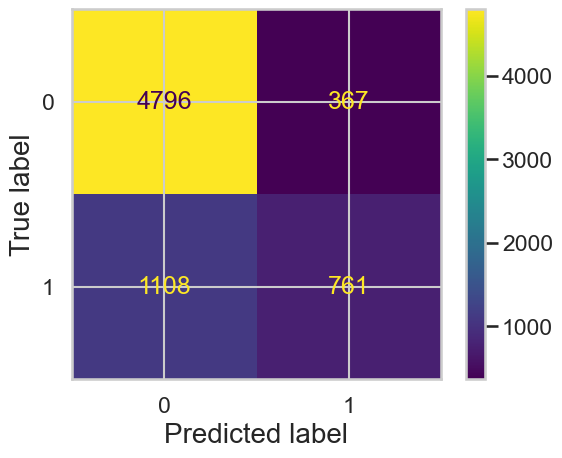

In [206]:
metrics.plot_confusion_matrix(grid_cv_tree_tot,X_tot,Y)

#### Metrics of Random Forest Classifier

In [207]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_tot, y_pred_rf_tot))
print("Precision",metrics.precision_score(y_test_tot,y_pred_rf_tot))
print("Recall",metrics.recall_score(y_test_tot,y_pred_rf_tot))
print("f1_score",metrics.f1_score(y_test_tot,y_pred_rf_tot))
print("f1_score",metrics.f1_score(y_train_tot,y_pred_rf_train_tot))

Accuracy: 0.8099526066350711
Precision 0.6854460093896714
Recall 0.5223613595706619
f1_score 0.5928934010152284
f1_score 0.646288209606987


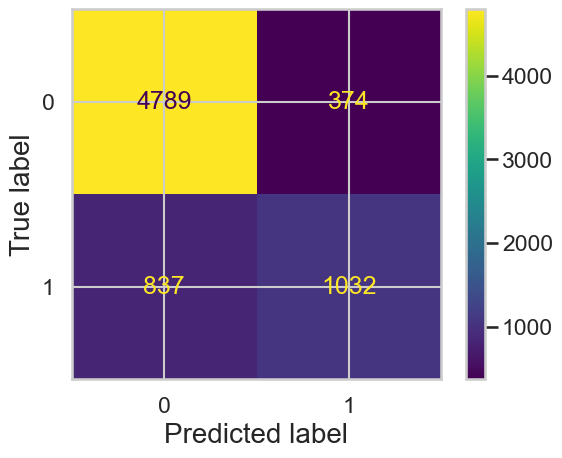

In [208]:
metrics.plot_confusion_matrix(grid_cv_rf_tot,X_tot,Y)

### SMOTE - Using Selected Features

In [120]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train_tot,y_train_tot)

### SMOTE - Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression
logreg_tot_smot=LogisticRegression(random_state=0)
logreg_tot_smot.fit(X_resampled,y_resampled)

LogisticRegression(random_state=0)

### SMOTE - Decision Tree

In [211]:
from sklearn.tree import DecisionTreeClassifier
dtree_tot_smot=DecisionTreeClassifier(criterion='gini',random_state=0)

In [228]:
max_features_range = np.arange(1,4,1)
param_grid = dict(max_features=max_features_range,max_depth=[1,2,3])
grid_cv_tree_tot_smot = GridSearchCV(estimator=dtree_tot_smot, param_grid=param_grid, cv=3)
grid_cv_tree_tot_smot.fit(X_train_tot,y_train_tot)
print(grid_cv_tree_tot_smot.best_params_)

{'max_depth': 3, 'max_features': 2}


### SMOTE - RANDOM FOREST

In [215]:
from sklearn.ensemble import RandomForestClassifier
rf_tot_smot=RandomForestClassifier(criterion='gini',random_state=0)


In [229]:
max_features_range = np.arange(1,5,1)
param_grid = dict(max_features=max_features_range,max_depth=[4,5,6],n_estimators=[50,100,50])
grid_cv_rf_tot_smot = GridSearchCV(estimator=rf_tot_smot, param_grid=param_grid, cv=3)
grid_cv_rf_tot_smot.fit(X_train_tot,y_train_tot)
print(grid_cv_rf_tot_smot.best_params_)

{'max_depth': 6, 'max_features': 4, 'n_estimators': 100}


In [230]:
y_pred_logreg_tot=logreg_tot.predict(X_test_tot)
y_pred_tree_tot=grid_cv_tree_tot_smot.predict(X_test_tot)
y_pred_rf_tot=grid_cv_rf_tot_smot.predict(X_test_tot)
y_pred_logreg_train_tot=logreg_tot.predict(X_resampled)
y_pred_tree_train_tot=grid_cv_tree_tot_smot.predict(X_resampled)
y_pred_rf_train_tot=grid_cv_rf_tot_smot.predict(X_resampled)


In [231]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#### Metrics of Logistic Regression

In [232]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_tot, y_pred_logreg_tot_smot))
print("Precision",metrics.precision_score(y_test_tot,y_pred_logreg_tot_smot))
print("Recall",metrics.recall_score(y_test_tot,y_pred_logreg_tot_smot))
print("f1_score",metrics.f1_score(y_test_tot,y_pred_logreg_tot_smot))
print("f1_score",metrics.f1_score(y_resampled,y_pred_logreg_train_tot_smot))

Accuracy: 0.737914691943128
Precision 0.5033259423503326
Recall 0.8121645796064401
f1_score 0.6214921286789871
f1_score 0.7155477031802119


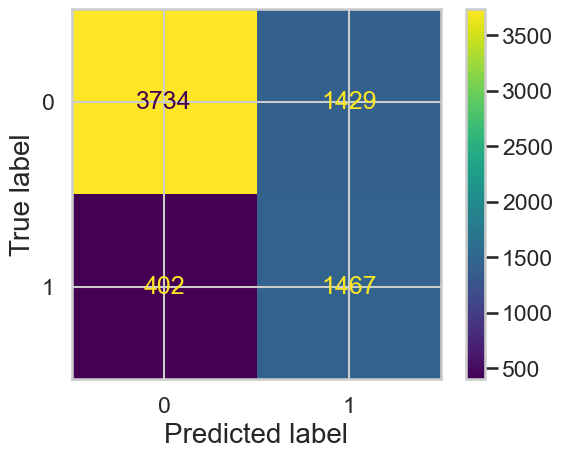

In [233]:
metrics.plot_confusion_matrix(logreg_tot_smot,X_tot,Y)

#### Metrics of Decision Tree Classifier

In [234]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_tot, y_pred_tree_tot_smot))
print("Precision",metrics.precision_score(y_test_tot,y_pred_tree_tot_smot))
print("Recall",metrics.recall_score(y_test_tot,y_pred_tree_tot_smot))
print("f1_score",metrics.f1_score(y_test_tot,y_pred_tree_tot_smot))
print("f1_score",metrics.f1_score(y_resampled,y_pred_tree_train_tot_smot))

Accuracy: 0.7872037914691943
Precision 0.6328502415458938
Recall 0.46869409660107336
f1_score 0.538540596094553
f1_score 0.7917823431426985


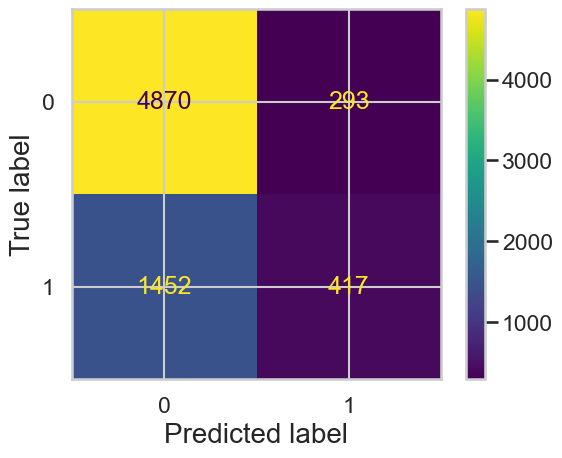

In [235]:
metrics.plot_confusion_matrix(grid_cv_tree_tot_smot,X_tot,Y)

#### Metrics of Random Forest Classifier

In [236]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_tot, y_pred_rf_tot_smot))
print("Precision",metrics.precision_score(y_test_tot,y_pred_rf_tot_smot))
print("Recall",metrics.recall_score(y_test_tot,y_pred_rf_tot_smot))
print("f1_score",metrics.f1_score(y_test_tot,y_pred_rf_tot_smot))
print("f1_score",metrics.f1_score(y_resampled,y_pred_rf_train_tot_smot))

Accuracy: 0.7113744075829384
Precision 0.47443762781186094
Recall 0.8300536672629696
f1_score 0.6037735849056605
f1_score 0.9198369565217391


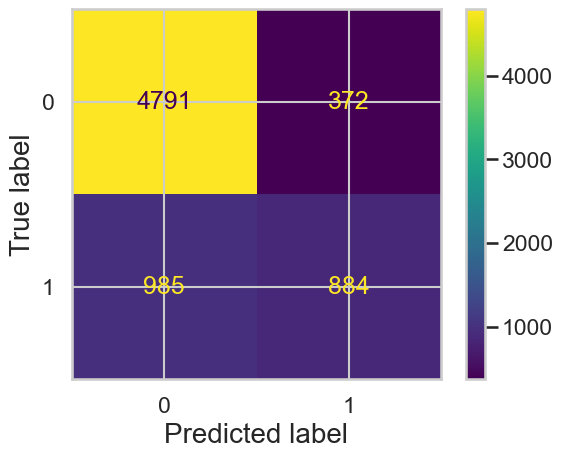

In [237]:
metrics.plot_confusion_matrix(grid_cv_rf_tot_smot,X_tot,Y)